<a href="https://colab.research.google.com/github/binhvd/Data-Analytics-3-Solutions/blob/main/7_Animal_Classification_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# use 2.8.3 to prevent bugs in 2.9
!pip install tensorflow-gpu==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 497.9 MB 33 kB/s 
     |████████████████████████████████| 1.4 MB 54.4 MB/s 
     |████████████████████████████████| 5.8 MB 50.3 MB/s 
     |████████████████████████████████| 462 kB 62.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.3


In [3]:
!wget https://cloud.ftk.de/index.php/s/R59madkJzDD8ZzX/download/animal.zip
!unzip animal.zip -d temp

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: temp/train/dog.5499.jpg  
  inflating: temp/train/dog.55.jpg   
  inflating: temp/train/dog.550.jpg  
  inflating: temp/train/dog.5500.jpg  
  inflating: temp/train/dog.5501.jpg  
  inflating: temp/train/dog.5502.jpg  
  inflating: temp/train/dog.5503.jpg  
  inflating: temp/train/dog.5504.jpg  
  inflating: temp/train/dog.5505.jpg  
  inflating: temp/train/dog.5506.jpg  
  inflating: temp/train/dog.5507.jpg  
  inflating: temp/train/dog.5508.jpg  
  inflating: temp/train/dog.5509.jpg  
  inflating: temp/train/dog.551.jpg  
  inflating: temp/train/dog.5510.jpg  
  inflating: temp/train/dog.5511.jpg  
  inflating: temp/train/dog.5512.jpg  
  inflating: temp/train/dog.5513.jpg  
  inflating: temp/train/dog.5514.jpg  
  inflating: temp/train/dog.5515.jpg  
  inflating: temp/train/dog.5516.jpg  
  inflating: temp/train/dog.5517.jpg  
  inflating: temp/train/dog.5518.jpg  
  inflating: temp/train/dog.5519.jpg  


In [4]:
!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [5]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


In [6]:
# Not enough memory to train 227x227
IMAGE_WIDTH=170
IMAGE_HEIGHT=170
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=32

In [7]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


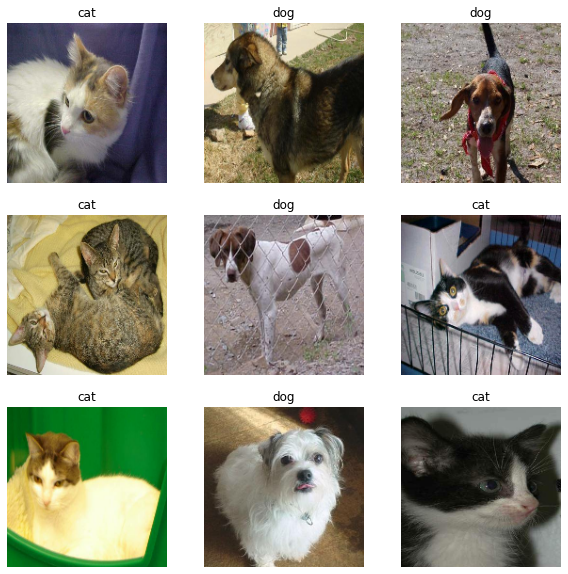

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [13]:
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = keras.models.Sequential([
    keras.layers.InputLayer((IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    keras.layers.Rescaling(1./255),  
    keras.layers.RandomZoom(.2),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(.2),
    keras.layers.RandomTranslation(.1, .1),

    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 170, 170, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 170, 170, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 170, 170, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 170, 170, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 170, 170, 3)      0         
 ranslation)                                                     
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 96)        3

In [14]:
epochs = 10

train = model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
625/625 [==============================] - 58s 76ms/step - loss: 1.1130 - accuracy: 0.5695 - val_loss: 1.0014 - val_accuracy: 0.5136 - lr: 1.0000e-04
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 0.7122 - accuracy: 0.6316 - val_loss: 0.6036 - val_accuracy: 0.6696 - lr: 1.0000e-04
Epoch 3/10
625/625 [==============================] - 28s 46ms/step - loss: 0.6144 - accuracy: 0.6876 - val_loss: 0.6107 - val_accuracy: 0.6624 - lr: 1.0000e-04
Epoch 4/10
624/625 [============================>.] - ETA: 0s - loss: 0.5674 - accuracy: 0.7244
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
625/625 [==============================] - 29s 46ms/step - loss: 0.5676 - accuracy: 0.7242 - val_loss: 0.5891 - val_accuracy: 0.6650 - lr: 1.0000e-04
Epoch 5/10
625/625 [==============================] - 29s 47ms/step - loss: 0.4894 - accuracy: 0.7689 - val_loss: 0.5434 - val_accuracy: 0.7598 - lr: 5.0000e-05
Epoch 6/10
625/625 [==============

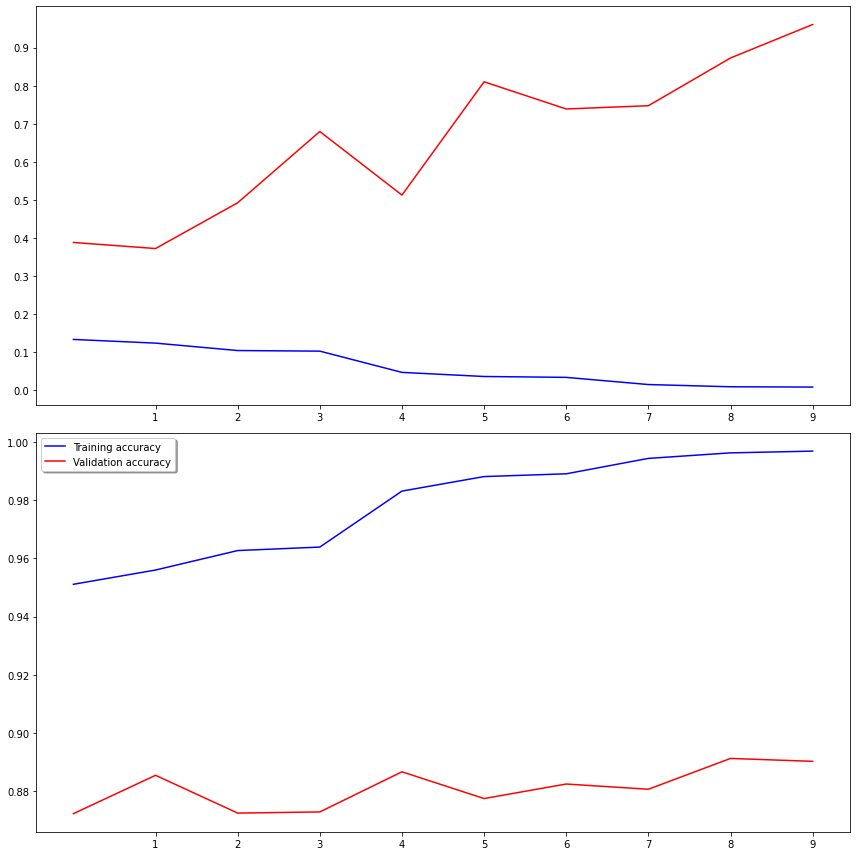

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(train.history['loss'], color='b', label="Training loss")
ax1.plot(train.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(train.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [15]:
!wget https://cloud.ftk.de/index.php/s/qQ5yn4Rw5yowNy9/download/animal-test.zip
!unzip animal-test.zip -d test

--2022-11-30 16:31:58--  https://cloud.ftk.de/index.php/s/qQ5yn4Rw5yowNy9/download/animal-test.zip
Resolving cloud.ftk.de (cloud.ftk.de)... 188.40.135.35
Connecting to cloud.ftk.de (cloud.ftk.de)|188.40.135.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65357 (64K) [application/zip]
Saving to: ‘animal-test.zip’

animal-test.zip     100%[===================>]  63.83K  --.-KB/s    in 0.02s   

2022-11-30 16:31:59 (2.99 MB/s) - ‘animal-test.zip’ saved [65357/65357]

Archive:  animal-test.zip
  inflating: test/cat1.jpg           
  inflating: test/cat2.jpg           
  inflating: test/cat3.jpg           
  inflating: test/dog1.jpg           
  inflating: test/dog2.jpg           
  inflating: test/dog3.jpg           
  inflating: test/dog4.jpg           


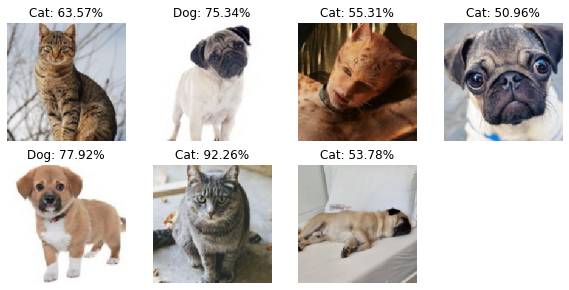

In [19]:
import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

plt.figure(figsize=(10, 10))
for i, file in enumerate(glob.glob('test/*')): 
    img = load_img(file, target_size=IMAGE_SIZE)

    # convert to array
    img = img_to_array(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))

    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    predict = model.predict(img)
    percent = predict[0][0]*100

    result = 'Cat'
    if percent < 50:
        result = 'Dog'
        percent = 100 - percent

    plt.title(result + ": " + str(round(percent, 2)) + "%")
    plt.axis("off")